<a href="https://colab.research.google.com/github/axiom-of-choice/DrivenDataCompetitions/blob/master/Notebook_for_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook contains my notebook for the Box-Plots for Education competition

The data can be found here : https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os 
os.getcwd()

'/content'

In [3]:
os.chdir('/content/drive/My Drive/datasets')

In [4]:
import pandas as pd 
train = pd.read_csv("TrainingData.csv")
test = pd.read_csv("TestData.csv")
format = pd.read_csv("SubmissionFormat.csv")
df = train

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Exploratory Data Analysis

In [5]:
display(train.info())
display(train.head())
display(train.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              400277 non-null  int64  
 1   Function                400277 non-null  object 
 2   Use                     400277 non-null  object 
 3   Sharing                 400277 non-null  object 
 4   Reporting               400277 non-null  object 
 5   Student_Type            400277 non-null  object 
 6   Position_Type           400277 non-null  object 
 7   Object_Type             400277 non-null  object 
 8   Pre_K                   400277 non-null  object 
 9   Operating_Status        400277 non-null  object 
 10  Object_Description      375493 non-null  object 
 11  Text_2                  88217 non-null   object 
 12  SubFund_Description     306855 non-null  object 
 13  Job_Title_Description   292743 non-null  object 
 14  Text_3              

None

,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
1,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
3,364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
4,47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
400272,109283,Professional Development,ISPD,Shared Services,Non-School,Unspecified,Instructional Coach,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,WORKSHOP PARTICIPANT,NaN,NaN,CURRICULUM RESOURCE TEACHER,NaN,NaN,NaN,STAFF DEV AND INSTR MEDIA,NaN,INST STAFF TRAINING SVCS,NaN,NaN,48.620000,NaN,GENERAL FUND,STAFF DEV AND INSTR MEDIA
400273,102430,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,NaN,FEDERAL GDPG FUND - FY,"Teacher,Retrd Shrt Term Sub",Regular,NaN,NaN,NaN,0.00431,"TITLE II,D",NaN,PROFESSIONAL-INSTRUCTIONAL,128.824985,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
400274,413949,Parent & Community Relations,NO_LABEL,School Reported,School,NO_LABEL,Other,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,School Liaison,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,PARENT/TITLE I,4902.290000,Misc,Schoolwide Schools,NaN
400275,433672,Library & Media,Instruction,School on Central Budgets,Non-School,Unspecified,Librarian,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,EDUCATIONAL RESOURCE SERVICES,LEVY OVERRIDE,Library Technician II,NaN,NaN,NaN,ED RESOURCE SERVICES,NaN,NON-PROJECT,NaN,OFFICE/ADMINISTRATIVE SUPPORT,4020.290000,MEDIA SUPPORT SERVICES,NaN,INSTRUCTIONAL STAFF
400276,415831,Substitute Compensation,Instruction,School Reported,School,Poverty,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Salaries And Wages For Substitute Professionals,NaN,"""Title Part A Improving Basic Programs""",TEACHER SUBSTITUTE POOL,NaN,Multilingual Dist Prof Development,Inservice Substitute Teachers Grant Funded,School,NaN,Instruction,Instruction And Curriculum,CERTIFIED SUBSTITUTE,46.530000,Accelerated Education,"""Title Part A Improving Basic Programs""",MISCELLANEOUS


Some of the column names correspond to features - descriptions of the budget items - such as the Job_Title_Description column. The values in this column tell us if a budget item is for a teacher, custodian, or other employee. Some columns correspond to the budget item labels you will be trying to predict with your model. For example, the Object_Type column describes whether the budget item is related classroom supplies, salary, travel expenses, etc.

FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee. Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

In [6]:
for i in range(len(df)):
    if df.loc[i,'FTE'] > 1 :
        df.loc[i,'FTE'] = df['FTE'].median()
    else:
        pass

          Unnamed: 0            FTE         Total
count  400277.000000  126071.000000  3.957220e+05
mean   225186.018537       0.399508  1.310586e+04
std    130025.142718       0.444498  3.682254e+05
min         2.000000      -0.087551 -8.746631e+07
25%    112601.000000       0.000792  7.379770e+01
50%    225243.000000       0.130927  4.612300e+02
75%    337722.000000       1.000000  3.652662e+03
max    450340.000000       1.000000  1.297000e+08


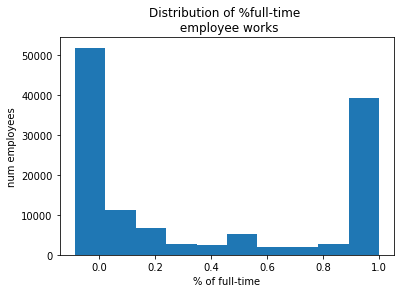

In [7]:
# Print the summary statistics
print(df.describe())
# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Create the histogram
plt.hist(df['FTE'].dropna())
# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
# Display the histogram
plt.show()

The high variance in expenditures makes sense (some purchases are cheap some are expensive). Also, it looks like the **FTE column is bimodal**. That is, there are some part-time and some full-time employees.

There are 9 columns of labels in the dataset. Each of these columns is a category that has many possible values it can take.

In [8]:
LABELS = ['Function','Use','Sharing','Reporting','Student_Type','Position_Type','Object_Type','Pre_K','Operating_Status']
# Define the lambda function: categorize_label
categorize_label = lambda x:x.astype('category')
# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label,axis=0)
# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


Observe there are over 100 unique labels

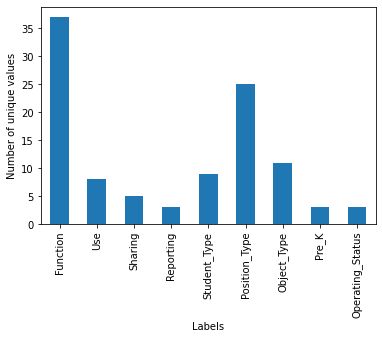

In [9]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique)
# Plot number of unique values for each label
num_unique_labels.plot(kind = 'bar')
# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
# Display the plot
plt.show()

We know that log loss metric penalizes highly confident wrong answers much more than any other type

# I'ts time to build a model.
 * Always a Good Approach to start with a very simple model
 * Gives a Sense of how challeging the problem is
 * We will start with a model on numeric data only
    * Want to go from raw data to predictions quickly
 * With Multiclass Logistic Regression
    * Trainin classifier on each label separately and use those to predict
 * Format predictions and save to a csv
 * Compute log loss metric

## Splitting the multiclass dataset won't work here
Some labels only appear in small fraction of the data
* If we split up our data randomly it may end up with labels in test set that never appear in training set
* Solution: *StratifiedShuffleSplit*
    * **Only works with a single target variable**
    * We have many target variables
    * We will provide a function: *multilabel_train_test_split()*

## Splitting the data

In [10]:
NUMERIC_COLUMNS = df.columns[df.dtypes == 'float' ]
from multilabel import multilabel_train_test_split
data_to_train = df[NUMERIC_COLUMNS].fillna(-1000)
labels_to_use = pd.get_dummies(df[LABELS])
X_train,X_test,y_train,y_test = multilabel_train_test_split(data_to_train,labels_to_use,size=0.2,seed=123)
print("X_train info:")
print(X_train.info())
print("\nX_test info:")
print(X_test.info())
print("\ny_train info:")
print(y_train.info())
print("\ny_test info:")
print(y_test.info())

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     320222 non-null  float64
 1   Total   320222 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     80055 non-null  float64
 1   Total   80055 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Columns: 104 entries, Function_Aides Compensa

## Training the model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train,y_train)
print("Accuracy: {}".format(clf.score(X_test,y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.0


**OneVsRestClassifier**
   * Treats each column of y independently
   * Fits a separate classifier for each of the columns

Do the predictions

In [12]:
holdout = test[NUMERIC_COLUMNS].fillna(-1000)
predictions = clf.predict_proba(holdout)

Formatting submission

In [13]:
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep="_").columns,
                             index=holdout.index,
                             data=predictions)
prediction_df.to_csv('predictions.csv')

In [14]:
from sklearn.metrics import log_loss
score = log_loss('predictions.csv')
print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

TypeError: ignored

# A very brief introduction to NLP 

## Tokenization
 Tokenization is the process of chopping up a character sequence into pieces called tokens.
 Often, tokens are separated by whitespace. But we can specify other delimiters as well.

 https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html
 
 Eg: Title I - Disadvantaged Children/Targeted Assistance
 Has 6 tokens


# n-grams
https://en.wikipedia.org/wiki/N-gram

## Creating a bag of words in scikit learn


In [15]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Create the token pattern that splits from spaces: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
# Fill missing values in df.Position_Extra
df.Position_Extra.fillna("", inplace=True)
# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)
# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)
# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

There are 385 tokens in Position_Extra if we split on non-alpha numeric
['1st', '2nd', '3rd', '4th', '56', '5th', '9th', 'a', 'ab', 'accountability', 'adaptive', 'addit', 'additional', 'adm', 'admin']


##  Combining text columns for tokenization

In order to get a bag-of-words representation for all of the text data in our DataFrame, you must first convert the text data in each row of the DataFrame into a single string.

In the previous exercise, this wasn't necessary because you only looked at one column of data, so each row was already just a single string. CountVectorizer expects each row to just be a single string, so in order to use all of the text columns, you'll need a method to turn a list of strings into a single string.

In [16]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS.to_list() + LABELS):
    """ converts all text in each row of data_frame to single vector """
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop,axis=1)
    # Replace nans with blanks
    text_data.fillna("",inplace=True)
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [17]:
df.drop('Unnamed: 0',axis=1,inplace=True)


Look at how much tokens and alpha-numeric tokens are in the dataset

In [18]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'
# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern = TOKENS_BASIC)
# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)
# Create the text vector
text_vector = combine_text_columns(df)
# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)
# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))
# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)
# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 4757 tokens in the dataset
There are 3284 alpha-numeric tokens in the dataset


Remember: Any step in the pipeline must be an object that implements the fit and transform methods. The **FunctionTransformer** creates an object with these methods out of any Python function that you pass to it. We'll use it to help select subsets of data in a way that plays nicely with pipelines.

We are working with numeric data that needs imputation, and text data that needs to be converted into a bag-of-words.

Using **Multiple types of processing: FeatureUnion**

## Using FunctionTransformer on the main dataset

In [19]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels

dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns,validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x:x[NUMERIC_COLUMNS], validate=False)

## Add a model to the pipeline

* The preprocessing step uses FeatureUnion to join the results of nested pipelines that each rely on FunctionTransformer to select multiple datatypes
* The model step stores the model object


In [20]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer',SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector',get_text_data),
                    ('vectorizer',CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train,y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy on budget dataset:  2.4982824308288053e-05


## Try a different class of model

One of the great strengths of pipelines is how easy they make the process of testing different models. You just have a simple one-line change, as you'll see in this exercise.

We'll try now an ensemble model: **Random Forest Classifier**




**Note:** Google Collab can't handle this model and we can't display in the notebook, you can try it in local if you *want*

In [ ]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf',RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

## Can we adjust the model or parameters to improve accuracy?

We're gonna change the parameter n_estimators of RandomForestClassifier(), whose default value is 10, to 15.

**Note:** Google Collab can't handle this model and we can't display in the notebook, you can try it in local if you *want*

In [ ]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Add model step to pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

# How many tokens?

Recall from previous cells that how we tokenize text affects the n-gram statistics used in your model.


Going forward, we'll use alpha-numeric sequences, and only alpha-numeric sequences, as tokens. Alpha-numeric tokens contain only letters a-z and numbers 0-9 (no other characters). In other words, we'll tokenize on punctuation to generate n-gram statistics.


## Deciding what's a word

Before we build up to the winning pipeline, it will be useful to look a little deeper into how the text features will be processed.

Here, we will use CountVectorizer on the training data X_train to see the effect of tokenization on punctuation.



In [21]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the text vector
text_vector = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer: text_features
text_features = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit text_features to the text vector
text_features.fit(text_vector)

# Print the first 10 tokens
print(text_features.get_feature_names()[:10])

['00a', '12', '1st', '2nd', '3rd', '4th', '5', '56', '5th', '6']


## N-gram range in scikit-learn

In this exercise we'll insert a CountVectorizer instance into the pipeline for the main dataset, and compute multiple n-gram features to be used in the model.

In order to look for ngram relationships at multiple scales, we will use the ngram_range parameter.

**Note:** We added a couple of new steps provided in the pipeline: *dim_red* and *scale*

The *dim_red* step uses a scikit-learn function called SelectKBest(), applying something called the chi-squared test to select the K "best" features. 

The *scale* step uses a scikit-learn function called MaxAbsScaler() in order to squash the relevant features into the interval -1 to 1. 

In [25]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

# Import other preprocessing modules
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 300 best features
chi_k = 300

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

## Implement interaction modeling in scikit-learn

It's time to add interaction features to the model. 

The *PolynomialFeatures* object in scikit-learn does just that, but here we're going to use a custom interaction object, SparseInteractions. 

**Interaction terms are a statistical tool that lets your model express what happens if two features appear together in the same row.**


** SparseInteractions ** does the same thing as PolynomialFeatures, but it uses sparse matrices to do so.


In [28]:
from SparseInteractions import *
# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int',SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

## Why is hashing a useful trick?


A hash function takes an input, in our case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

E.g. {'and': 780, 'fluids': 354, 'fuel': 895, 'petro': 354, 'vend': 785}

**In fact, python dictionaries ARE hash tables!**

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.


**HashingVectorizer** acts just like **CountVectorizer** in that it can accept *token_pattern* and *ngram_range* parameters. The important difference is that it creates hash values from the text, so that we get all the computational advantages of hashing!

In [32]:
# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
hashing_vec = HashingVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)

# Create DataFrame and print the head
hashed_df = pd.DataFrame(hashed_text.data)
print(hashed_df.head())

          0
0  0.377964
1  0.755929
2  0.377964
3  0.377964
4  0.200000


## Build the Winning Model!

The parameters non_negative=True, norm=None, and binary=False make the HashingVectorizer perform similarly to the default settings on the CountVectorizer so you can just replace one with the other.

In [41]:
# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate the winning model pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer',HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                      norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

https://github.com/datacamp/course-resources-ml-with-experts-budgets/blob/master/notebooks/1.0-full-model.ipynb
